In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
 
import matplotlib.pyplot as plt
import numpy as np
import os

import torch 
import utils 

import pprint

In [3]:
path = "./out/pipeline_results/GroundingDinoTiny_SamWrapper_b_categories_coco_train_4_09_03"
results, config, array_boxes, array_masks = utils.load_results(path, print_conf=True)
# index array translates index in other arrays to index in the dataset

{'batch_size': 2,
 'class_list': {'classes': ['animal',
                            'person',
                            'fruit',
                            'food',
                            'vegetable',
                            'vehicle',
                            'building',
                            'tool',
                            'clothing',
                            'instrument',
                            'furniture',
                            'toy',
                            'appliance',
                            'weapon',
                            'plant',
                            'body part',
                            'accessory',
                            'container',
                            'machine',
                            'electronics',
                            'drink',
                            'utensil',
                            'musical instrument'],
                'name': 'categories'},
 'dataset': {'class_name': 'Coco

In [7]:
print(results.keys())

pprint.pprint(results["classless mAP - detection"])
pprint.pprint(results["classless mAP - segmentation"])

dict_keys(['mean det IoU', 'mean seg IoU', 'classless mAP - detection', 'classless mAP - segmentation', 'classful mAP - detection', 'classful mAP - segmentation'])
{'classes': 0,
 'map': 0.6794682741165161,
 'map_50': 0.765354335308075,
 'map_75': 0.719456136226654,
 'map_large': 0.8762140274047852,
 'map_medium': 0.5108910799026489,
 'map_per_class': -1.0,
 'map_small': -1.0,
 'mar_1': 0.29230770468711853,
 'mar_10': 0.6692307591438293,
 'mar_100': 0.9153845906257629,
 'mar_100_per_class': -1.0,
 'mar_large': 0.987500011920929,
 'mar_medium': 0.800000011920929,
 'mar_small': -1.0}
{'classes': 0,
 'map': 0.12541444599628448,
 'map_50': 0.17533685266971588,
 'map_75': 0.13261084258556366,
 'map_large': 0.13123498857021332,
 'map_medium': 0.19785478711128235,
 'map_per_class': -1.0,
 'map_small': -1.0,
 'mar_1': 0.06923077255487442,
 'mar_10': 0.3769230842590332,
 'mar_100': 0.692307710647583,
 'mar_100_per_class': -1.0,
 'mar_large': 0.6625000238418579,
 'mar_medium': 0.7400000095367432

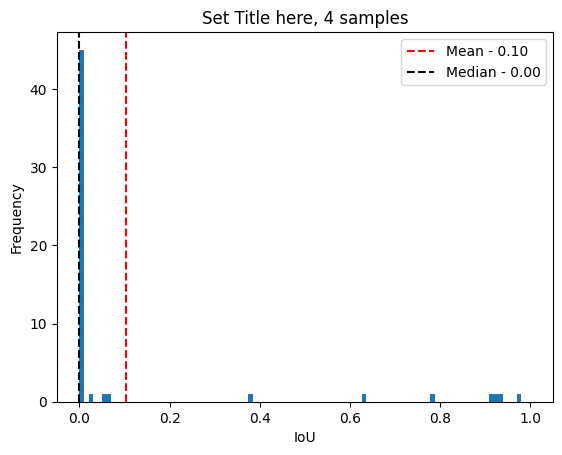

In [6]:
lspace = np.linspace(0.0, 1.0, 100)

# Calculate the number of objects in each bin
hist, bins, _ = plt.hist(IoU_array, bins=lspace)

# Find the bin index where the mean value of IoU_array falls
mean_threshold = np.mean(IoU_array)
median_threshold = np.median(IoU_array)
plt.axvline(x=mean_threshold, color="red", linestyle="--")
plt.axvline(x=median_threshold, color="black", linestyle="--")
# Add labels and title
plt.xlabel("IoU")
plt.ylabel("Frequency")
size = (config["max_batch"] * config["batch_size"])
plt.title(f"Set Title here, {size} samples")

mean = "{:.2f}".format(mean_threshold)
median = "{:.2f}".format(median_threshold)
plt.legend([f"Mean - {mean}", f"Median - {median}"])
# Show the plot
plt.show()

### Comparison


In [ ]:
# TODO: rewrite for the new saving format (array index etc.)

In [2]:
path1 = "./out/pipeline_results/gt_boxes_middle_sam1_b_coco_val_600_08_26"
_, config1, array_boxes1, array_masks1 = utils.load_results(path1)
size1= (config1["max_batch"] * config1["batchsize"])

In [4]:
path2 = "./out/pipeline_results/gt_boxes_sam1_b_coco_val_600_08_26"
_, config2, array_boxes2, array_masks2 = utils.load_results(path2)
size2= (config2["max_batch"] * config2["batchsize"])

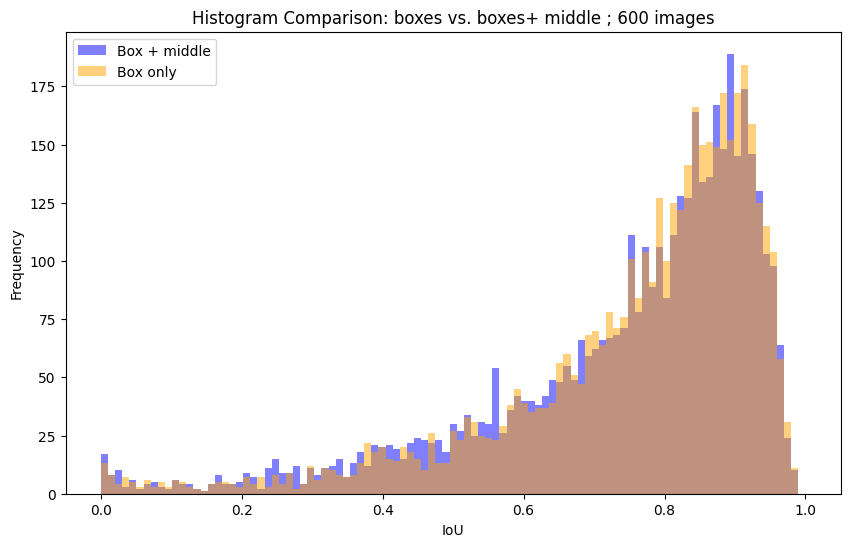

In [5]:
# put 2 arrays of IoUs here, here is an example with masks and boxes, not important
first = array_masks1
second = array_masks2

plt.figure(figsize=(10, 6))

# Plot the "large" histogram
bins = np.linspace(0, 1, 100)
plt.hist(first, bins=bins, alpha=0.5, label="Box + middle", color="blue")

# Plot the "base" histogram
plt.hist(second, bins=bins, alpha=0.5, label='Box only', color='orange')

# Add labels and title
plt.xlabel('IoU')
plt.ylabel('Frequency')
assert(size1 == size2)
plt.title(f"Histogram Comparison: boxes vs. boxes+ middle ; {size} images")

# Add legend
plt.legend()

# Show the plot
plt.show()